# Armita Bahrudi - 810100591

Artificial Intelligence - CA#06: *Clustering* - fall 1402 \
In this notebook, We use news classifier.

In [927]:
import re
import hazm
import pandas as pd
import parsivar as wp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [928]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from arabic_reshaper import reshape
from sklearn.decomposition import PCA
from bidi.algorithm import get_display
from sklearn.preprocessing import StandardScaler
from wordcloud_fa import WordCloudFa as WordCloud
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import homogeneity_score, silhouette_score

In [929]:
TEST_DATA_PATH = 'test.csv'
TRAIN_DATA_PATH = 'train.csv' 
PALETTE = ["#2E7B7C", "#3B9EA0", "#79CBCD", "#FFCAD4", "#FFBCDA", "#F39EC7", "#F765A3"]
COLOR_MAP = mcolors.ListedColormap(PALETTE)

In [930]:
show_persian = lambda x: get_display(reshape(x))

## Load and Examine DataFrame

In [931]:
train_dataset = pd.read_csv(TRAIN_DATA_PATH, encoding='utf-8')
train_dataset

,label,content
0,فناوری,گزارش های منتشر شده حاکی از آن است که کاربران ...
1,ورزشی,سوپر استار سینما و از قهرمانان سابق ووشو ــ کو...
2,حوادث,مدیرعامل شرکت عمران آب کیش از فوت یک نفر در آت...
3,فناوری,یک نوجوان انگلیسی به اتهام هک حساب‌های کاربری ...
4,سلامت,دانشمندان در جدیدترین مطالعات خود اثرات جدید و...
...,...,...
8995,حوادث,شانزدهم مهر امسال درپی تماس با مرکز فوریت‌های ...
8996,ورزشی,اتحادیه فوتبال ترینیداد و توباگو اعلام کرده تی...
8997,فرهنگی/هنری,اسامی 18 فیلم بخش مسابقه مستند ششمین دوره جشنو...
8998,حوادث,کامیونت حامل بار تخته‌های چوبی عصر دیروز چهارش...


In [932]:
NEWS_TYPES = list(train_dataset['label'].unique())
NEWS_TYPES

['فناوری', 'ورزشی', 'حوادث', 'سلامت', 'سیاسی', 'فرهنگی/هنری']

In [933]:
label_counts = train_dataset['label'].value_counts()
label_counts = pd.DataFrame(label_counts)
label_counts = label_counts.reset_index()
label_counts.columns = ['label', 'count']
display(label_counts)

,label,count
0,فناوری,1500
1,ورزشی,1500
2,حوادث,1500
3,سلامت,1500
4,سیاسی,1500
5,فرهنگی/هنری,1500


<Axes: title={'center': 'Number of samples per label'}, xlabel='label'>

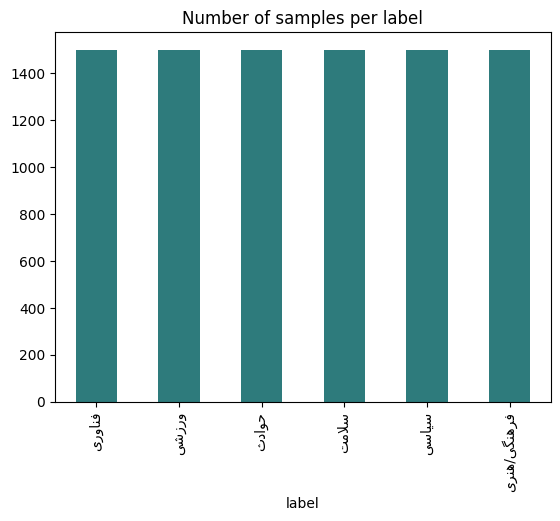

In [934]:
labels_freq = train_dataset['label'].value_counts()
labels_freq.index = labels_freq.index.map(show_persian)
labels_freq.plot(
    cmap=COLOR_MAP,
    kind='bar', 
    title='Number of samples per label',
    )

## Preprocessing Data

When data is imbalanced, meaning that the number of samples in each class or cluster is different, it can introduce challenges in the clustering process. Some potential problems include


### Impact of Majority Class Data:
If one class or cluster has a larger number of samples, clustering algorithms may incline towards it incorrectly, leading to inaccurate results.

### Reduced Accuracy and Algorithm Performance:
Clustering algorithms' accuracy may decrease when one or more clusters have fewer samples, resulting in a decline in overall performance.


To address these issues, you can use the following solutions:

- **Data Balancing**:
    - Balancing the data by increasing the number of samples in the minority class can be achieved through techniques such as adding synthetic samples or removing excess samples from the majority classes.
- **Use of Specialized Clustering Algorithms**:
    - Some clustering algorithms, like DBSCAN (Density-Based Spatial Clustering of Applications with Noise), are robust to imbalanced data. Using these algorithms can yield better results in imbalanced conditions.
- **Utilizing Meaningful Features**:
    - If the number of samples in a class is low, investigating and using more meaningful features may lead to better discrimination. \\
- **Alternative Metrics such as F-score**:
    - Instead of accuracy, consider using other metrics like F-score, which takes into account precision and recall.

#### Lemmatization in Persian:
- **Definition:**
  Lemmatization is the process of reducing a word to its base or dictionary form, known as the lemma. The lemma is the canonical, or the most general, form of a word.
- **Example in Persian:**
  The lemmatization of the Persian verb "می‌روم" would be "رفتن," as it returns the base form of the verb.

#### Stemming in Persian:
- **Definition:**
  Stemming is a more aggressive approach aimed at removing prefixes or suffixes from words to obtain a common root form (stem). It doesn't necessarily result in valid words. Persian stemming might be rule-based and focus on heuristic methods to truncate word endings.
- **Example in Persian:**
  The stem of the Persian verb "می‌روم" might be "رفت," which is the common root form without considering grammatical features.


``Let's understand witch one of them is better for our application:``

In [935]:
def test_cleaning_approach(approach: callable):
    test_words = ['دیدم', 'دیدند', 'دیده بودند', 'داشتند میدیدند', 'خواهند دید', 'می بینی', 'دارم میبینم', 'مغازه ها','بز ها', 'دختران','بینوایان','اوراق']
    for w in test_words:
        print(f"{w} -> {approach(w)}")

### Stemming-parsivar

In [936]:
test_cleaning_approach(wp.FindStems().convert_to_stem)

دیدم -> دید&بین
دیدند -> دید&بین
دیده بودند -> دید&بین
داشتند میدیدند -> دید&بین
خواهند دید -> دید&بین
می بینی -> دید&بین
دارم میبینم -> دید&بین
مغازه ها -> مغازه
بز ها -> بز
دختران -> دختر
بینوایان -> بینوا
اوراق -> اوراق


### Stemming-hazm

In [937]:
test_cleaning_approach(hazm.Stemmer().stem)

دیدم -> دید
دیدند -> دیدند
دیده بودند -> دیده بودند
داشتند میدیدند -> داشتند میدیدند
خواهند دید -> خواهند دید
می بینی -> می بین
دارم میبینم -> دارم میبین
مغازه ها -> مغازه 
بز ها -> بز 
دختران -> دخ
بینوایان -> بینوا
اوراق -> اوراق


### Lemmatizing-hazm

In [938]:
test_cleaning_approach(hazm.Lemmatizer().lemmatize)

دیدم -> دید#بین
دیدند -> دید#بین
دیده بودند -> دیده بودند
داشتند میدیدند -> داشتند میدیدند
خواهند دید -> خواهند دید
می بینی -> می بینی
دارم میبینم -> دارم میبینم
مغازه ها -> مغازه ها
بز ها -> بز ها
دختران -> دختران
بینوایان -> بینوا
اوراق -> اوراق


parsivar works much better on verbs, so we use it.

### Stop-Words

We could deal with stop words using following approach:
- using pre-trained models
- collect some common stop words and generate our model

We collected stop words from different source and turned them to our normalized form.

In order to make my vocabulary less crowded, we consider the root(stem) form of words and verbs 
and convert the input data to the same form.

In [939]:
class StopWordDetector:
    def __init__(self, repo='stop-words.txt', n_gram=None) -> None:
        self.n_gram=n_gram
        with open(repo, 'r', encoding='utf-8') as f:
            self.stop_words = set(re.sub('[۰-۹]|[0-9]', '', f.read()).splitlines())
            print(f"Stop-Word-Detection model loaded with {len(self.stop_words)} words")
        if n_gram:
            print("- N-gram functionality enabled")
        else:
            print("- N-gram functionality disabled")
    
    def is_stop_word(self, word: str) -> bool:
        if self.n_gram:
            return any(w in self.stop_words for w in word.split(','))
        return word in self.stop_words
    
    def filter_words(self, _words: list[str]) -> list[str]:
        return [w for w in _words if not self.is_stop_word(w)]

In [940]:
words = ['سلام', 'من', 'به', 'دنیا', 'خوش', 'آمد','با توجه به','ضمن','همراه','عین','مثلا','چگونه','امروزه']
model = StopWordDetector()
for _w in words:
    print(f"{_w} -> if stop word: {model.is_stop_word(_w)}")

del words, _w, model

Stop-Word-Detection model loaded with 220 words
- N-gram functionality disabled
سلام -> if stop word: True
من -> if stop word: True
به -> if stop word: True
دنیا -> if stop word: False
خوش -> if stop word: True
آمد -> if stop word: True
با توجه به -> if stop word: True
ضمن -> if stop word: True
همراه -> if stop word: True
عین -> if stop word: True
مثلا -> if stop word: True
چگونه -> if stop word: True
امروزه -> if stop word: True


### Normalize Data

Our normalization's steps:
- delete unnecessary characters
- Extraction words root(stem)
- delete unnecessary words

In [941]:
class Normalizer:
    def __init__(self, n_gram=None):
        self.n_gram = n_gram
        norm = hazm.Normalizer()
        self.basic_normalizer = norm.normalize
        token = wp.Tokenizer()
        self.word_tokenizer = token.tokenize_words
        self.stop_word_detector = StopWordDetector(n_gram=n_gram).filter_words
        stem = wp.FindStems()
        self.stemmer = lambda w: stem.convert_to_stem(w).split('&')[0]
    
    def __prepare_statement(self, statement: str):
        statement = self.basic_normalizer(statement)
        number={'0':'۰','1':'۱','2':'۲','3':'۳',
                '4':'۴','5':'۵','6':'۶','7':'۷',
                '8':'۸','9':'۹'}
        
        punctuations = [
            '(',')','\'','\"',';','.',',',':',';','[',']','{','}','،','؛','»','«',
            '؟','!','?','٬','\n','\r','_',',', '.', '-', '...',
            ]
        for p in punctuations:
            statement = statement.replace(p, '')
        for i,j in number.items():
            statement = statement.replace(j,i)
        statement = ' '.join(re.findall(r'(?:[^\W\d_]+\d|\d+[^\W\d_])[^\W_]*|[^\W\d_]+',statement))
        statement = statement.replace('\u200c', '').replace('\u200e', '')
        return statement

    def __prepare_words(self, _words: list[str]) -> list[str]:
        if self.stemmer is None:
           stemmed = _words
        else:
            stemmed = [
                self.stemmer(word).replace('\u200c', '').replace('\u200f','').replace('\u2066','') for word in _words
                ]
        if self.n_gram is not None:
            prepared = []
            for n in self.n_gram:
                prepared.extend(
                    [','.join(stemmed[i:i+n]) for i in range(len(stemmed)-n+1)]
                    )
        else : 
            prepared = stemmed
            
        return prepared
    
    def __filter_stop_words(self, _words: list[str]) -> list[str]:
        if self.stop_word_detector is None:
            return _words
        filtered = self.stop_word_detector(_words)
        return filtered
    
    def normalize(self, statement: str) -> list[str]:
        prepared = self.__prepare_statement(statement)
        tokens = self.word_tokenizer(prepared)
        normalized = self.__filter_stop_words(self.__prepare_words(tokens))
        return normalized
    
    def str_normalize(self, statement: str) -> str:
        return ' * '.join(self.normalize(statement))

In [942]:
normalizer = Normalizer()
normalizer.normalize(train_dataset['content'][12])

Stop-Word-Detection model loaded with 220 words
- N-gram functionality disabled


['علیرضا',
 'معزی',
 'قطبی',
 'فضا',
 'عمومی',
 'پرشماری',
 'بحران',
 'کاهش',
 'اعتماد',
 'عمومی',
 'منبع',
 'اطلاعاتی',
 'پی',
 'داشته',
 'زمانه',
 'عارضه',
 'قطبی',
 'فضا',
 'عمومی',
 'تیتر',
 'توئیت',
 'انتقام',
 'جوی',
 'مرجعیت',
 'زدود',
 'جای',
 'گذاشتن',
 'زمین',
 'سوخته',
 'انجامیده',
 'یافتن',
 'نهاد',
 'اجتماعی',
 'بتواند',
 'فراز',
 'نفرت',
 'پراکند',
 'منازعات',
 'مرجع',
 'فراگیر',
 'بی',
 'طرف',
 'شکل',
 'قضاوت',
 'عمومی',
 'دشوار',
 'چکاچک',
 'نزاع',
 'روایت',
 'بحران',
 'الزاما',
 'حقیقت',
 'معمولا',
 'پروژه',
 'متن',
 'بی',
 'اعتبارسازی',
 'سیاسی',
 'میدان',
 'داری',
 'شهروند',
 'تعدد',
 'تناقض',
 'روایت',
 'چندپاره',
 'فقدان',
 'اعتماد',
 'گوشه',
 'دور',
 'انفعال',
 'نظاره',
 'ایستاد',
 'پی',
 'آمدن',
 'بحران',
 'تکرار',
 'چرخه',
 'عمیق',
 'بی',
 'اعتمادی',
 'انجامید',
 'بحران',
 'عمدتا',
 'محصول',
 'انتخاب',
 'دولت',
 'سیاستگذاران',
 'نبوده',
 'دولت',
 'رئیس',
 'جمهوری',
 'روحانی',
 'نخستین',
 'بار',
 'بحران',
 'شکاف',
 'سیاسی',
 'تنها',
 'رفتاری',
 'غریزی',
 'اکتفا',

## Implement Model

A feature vector is a crucial concept in computer science, machine learning, and data analysis. It serves as a representation of data, capturing meaningful features. Feature vectors offer several advantages:

- *Transformation Tool:*
    - Feature vectors transform raw data into a processed format suitable for machine learning, aiding in computational efficiency.
- *Dimensionality Reduction:*
    - By reducing the number of data dimensions, feature vectors simplify computations and enhance algorithm performance.
- *Meaningful Representation:* 
    - Feature vectors extract meaningful data features, facilitating the understanding of patterns and characteristics in the data.
- *Applicability in Algorithms:* 
    - Feature vectors are widely used in machine learning algorithms as essential inputs for model training and other computations.
- *Data Volume Efficiency:* 
    - Feature vectors help reduce data volume, making it more manageable for storage and processing.


``Word2Vec`` and ``Doc2Vec`` are models developed by Tomas Mikolov and his team at Google to learn distributed representations of words and documents in a continuous vector space. These models belong to the family of neural network-based algorithms and are widely used for natural language processing tasks.

- **Word2Vec**:
    - *Objective*:

    The main objective of Word2Vec is to learn continuous vector representations (word embeddings) for words based on their context in a given corpus.
    - *How it Works*:

        - ***Skip-gram Model***:
            The skip-gram model is one of the two architectures used by Word2Vec. In this model, the algorithm predicts the context words (words surrounding the target word) given a target word.
        - ***Continuous Bag-of-Words (CBOW) Model***:
            The CBOW model is the other architecture used by Word2Vec. In this model, the algorithm predicts the target word based on its context (surrounding words).
        - ***Neural Network Architecture***:
            Both skip-gram and CBOW models use a shallow neural network with a single hidden layer. The input layer corresponds to the words, and the output layer corresponds to the context or target words.
        - ***Training***:
            During training, the model adjusts its parameters (word vectors) to maximize the likelihood of predicting the correct context words for a given target word.
        _ ***Result***:
            The trained Word2Vec model provides word embeddings, which are vectors in a continuous space, where words with similar meanings or contexts have similar vector representations.
- **Doc2Vec**:
    - *Objective*:

    Doc2Vec extends the idea of Word2Vec to learn distributed representations (document embeddings) for entire documents.
    - *How it Works*:

        - ***Paragraph Vector (PV) Model***:
            The PV model, also known as Doc2Vec, is used to generate vectors for documents. It extends the skip-gram model of Word2Vec by adding an extra vector representing the document.
        _ ***Two Training Approaches***:
            - ****Distributed Memory (DM)****:
                In this approach, the model considers the context of words as well as a memory vector that represents the entire document.
            - ****Distributed Bag of Words (DBOW)****:
                In this approach, the model predicts words in a small window given only the document vector.
        - ***Training***:
            The model is trained to adjust both word vectors and document vectors simultaneously, allowing it to capture the semantics of words and the overall context of documents.
        - ***Result***:
            The trained Doc2Vec model provides document embeddings, allowing similarity comparisons between documents.

In [943]:

class Clusterer:
    def __init__(self, normalizer):
        self.model = None
        self.documents = []
        self.normalizer = normalizer

    def preprocess_text(self, text):
        return self.normalizer.normalize(text)

    def preprocess_documents(self, news_data):
        tagged_data = [TaggedDocument(words=self.preprocess_text(text), tags=[str(i)]) for i, text in enumerate(news_data['content'])]
        #preprocessed_documents = []
        #for idx, news_item in enumerate(news_data):
        #    tokens = self.preprocess_text(news_item)
        #    preprocessed_documents.append(TaggedDocument(tokens, [idx]))
        return tagged_data

    def train_model(self, news_data, vector_size=100, window=5, min_count=1, workers=4, epochs=10):
        self.documents = self.preprocess_documents(news_data)
        self.model = Doc2Vec(
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            workers=workers,
            epochs=epochs
        )
        self.model.build_vocab(self.documents)
        self.model.train(self.documents, total_examples=self.model.corpus_count, epochs=self.model.epochs)

    def calculate_accuracy(self, vectors, cluster_labels, datast):
        true_labels = []
        for l in datast['label']:
            for i in range(len(NEWS_TYPES)):
                if l == NEWS_TYPES[i]:
                    true_labels.append(i)

        # Calculate homogeneity and silhouette scores
        homogeneity = homogeneity_score(true_labels, cluster_labels)
        silhouette = silhouette_score(vectors, cluster_labels)

        # Print the scores
        print(f'Homogeneity Score: {homogeneity}')
        print(f'Silhouette Score: {silhouette}')
    
    def cluster_news_K_Means(self, num_clusters=3, dataset=train_dataset):
        if self.model is None:
            raise ValueError("Model not trained. Call train_model() first.")
        
        d = self.preprocess_documents(dataset)
        vectors = [self.model.infer_vector(doc.words) for doc in d]

        kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100)
        kmeans = kmeans_model.fit(vectors)

        # Assign cluster labels to documents
        cluster_labels = kmeans.labels_

        # Dimensionality reduction for visualization (using PCA)
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(vectors)

        # Scatter plot for document clustering
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap=COLOR_MAP)
        plt.title('NEWSs Clustering with K-MEANS')
        plt.show()
        self.calculate_accuracy(vectors, cluster_labels, dataset)

    def cluster_news_DBSCAN(self, eps=0.5, min_samples=5, dataset=train_dataset):
        if self.model is None:
            raise ValueError("Model not trained. Call train_model() first.")
        
        d = self.preprocess_documents(dataset)
        vectors = [self.model.infer_vector(doc.words) for doc in d]
        scaler = StandardScaler()
        normalized_data = scaler.fit_transform(vectors)
        # Perform PCA for dimensionality reduction
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(normalized_data)

        # Perform DBSCAN clustering
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(reduced_features)

        # Scatter plot for document clustering
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap=COLOR_MAP)
        plt.title('NEWSs Clustering with DBSCAN')
        plt.show()
        self.calculate_accuracy(vectors, cluster_labels, dataset)


In [944]:


normalizer = Normalizer()
clusterer = Clusterer(normalizer)
clusterer.train_model(train_dataset)

Stop-Word-Detection model loaded with 220 words
- N-gram functionality disabled


- *K-Means*:

    - **Advantages**:

        - Simplicity: K-Means is a simple and easily understandable method for clustering data.
        - Efficiency with Large Datasets: Generally, K-Means works well with large volumes of data.
        - Suitable for Specific and Known Number of Clusters: If the number of clusters and their locations are known, K-Means is usually the better choice.
    - **Disadvantages**:

        - Sensitivity to Initial Centroid Positions: K-Means results are sensitive to the initial positions of cluster centroids, and different initializations may lead to different results.
        - Ineffective with Irregular Clusters: If clusters have irregular shapes or different sizes, K-Means may perform poorly.
- *DBSCAN*:

    - **Advantages**:

        - Capability to Identify Clusters with Various Shapes and Sizes: DBSCAN can work well with clusters of various shapes and sizes, and it performs better than K-Means on datasets with non-linear distributions.
        - Identification of Noise Points: DBSCAN also identifies noise points and separates them from clusters.
        - No Need for a Predefined Number of Clusters: DBSCAN does not require a predefined number of clusters, and it can automatically determine the number of clusters.
    - **Disadvantages**:

        - Sensitivity to Tuning Parameters: DBSCAN is sensitive to tuning parameters such as eps and min_samples, which require careful adjustment.
        - Reduced Performance in High-Dimensional Data: Like many clustering algorithms, DBSCAN may perform poorly on high-dimensional data.
        - Potential Slowness in Large Datasets: DBSCAN may be slow for large datasets with high time complexity.

### Train Dataset

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


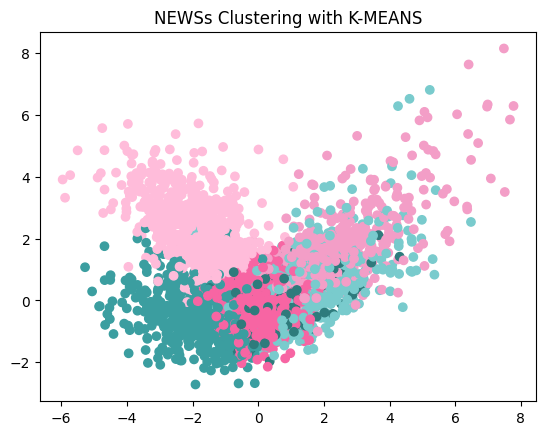

Homogeneity Score: 0.32932632442891335
Silhouette Score: 0.18093937635421753


In [945]:
num_clusters = len(NEWS_TYPES)
clusterer.cluster_news_K_Means(num_clusters, dataset=train_dataset)

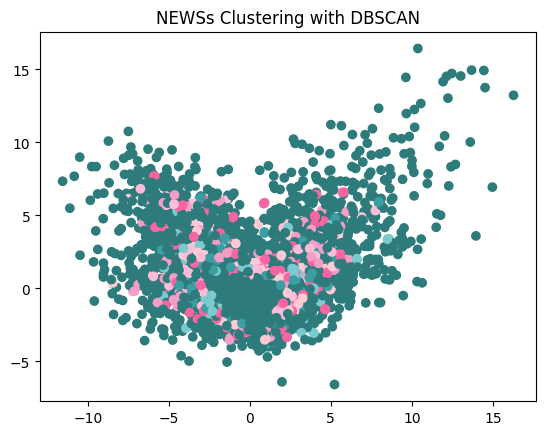

Homogeneity Score: 0.19247050643821378
Silhouette Score: -0.13371282815933228


In [956]:
clusterer.cluster_news_DBSCAN(eps=0.09 ,min_samples = 2, dataset= train_dataset)

### Test Datasets

In [947]:
test_dataset = pd.read_csv(TRAIN_DATA_PATH, encoding='utf-8')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


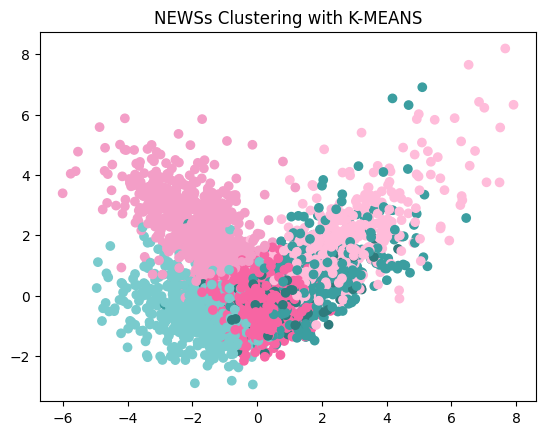

Homogeneity Score: 0.329240096143188
Silhouette Score: 0.1789720207452774


In [948]:
num_clusters = len(NEWS_TYPES)
clusterer.cluster_news_K_Means(num_clusters, dataset=test_dataset)

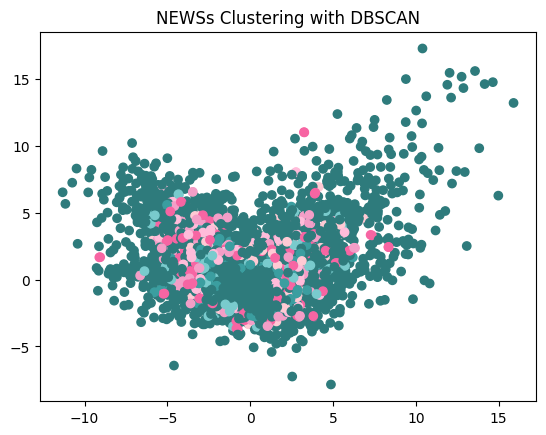

Homogeneity Score: 0.19154966576175225
Silhouette Score: -0.1949869692325592


In [953]:
clusterer.cluster_news_DBSCAN(eps=0.09 ,min_samples = 2, dataset= test_dataset)

we know number of classes and K-Means works too much better than DBSCAN.